In [1]:
from alanine_dipeptide_example import *

openmmtools version: 0.15.0
openmm version: 7.2.0.dev-fb607c7
# of conditions in this experiment: 45


In [2]:
from glob import glob

In [3]:
fnames = glob('ala2-results/*.pkl')
len(fnames)

36

In [4]:
from pickle import Unpickler

results = []
for fname in fnames:
    with open(fname, 'rb') as f:
        results.append(Unpickler(f).load())

In [5]:
result = results[0]['result']

In [6]:
result.keys()

dict_keys(['w_shads', 'w_tots', 'w_prots', 'reduced_DeltaEs'])

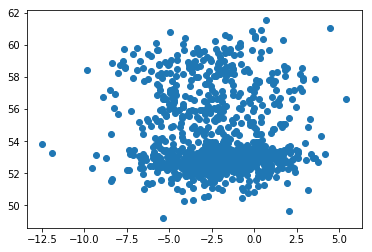

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(result['w_shads'][1:], result['w_prots'][1:])

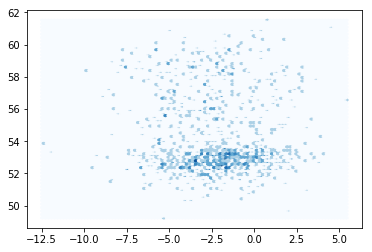

In [8]:
plt.hexbin(result['w_shads'][1:], result['w_prots'][1:], cmap='Blues', bins='log')

In [9]:
results[0]['condition']

Condition(timestep=Quantity(value=4.0, unit=femtosecond), switching_time=Quantity(value=0.1, unit=picosecond), n_switching_steps=25, splitting='VVVR (OVR-H-RVO)')

In [10]:
for r in results:
    if 'VVVR' in r['condition'].splitting:
        print(r['condition'])

Condition(timestep=Quantity(value=4.0, unit=femtosecond), switching_time=Quantity(value=0.1, unit=picosecond), n_switching_steps=25, splitting='VVVR (OVR-H-RVO)')
Condition(timestep=Quantity(value=4.0, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=250, splitting='VVVR (OVR-H-RVO)')
Condition(timestep=Quantity(value=4.0, unit=femtosecond), switching_time=Quantity(value=0.5, unit=picosecond), n_switching_steps=125, splitting='VVVR (OVR-H-RVO)')
Condition(timestep=Quantity(value=1.0, unit=femtosecond), switching_time=Quantity(value=0.1, unit=picosecond), n_switching_steps=100, splitting='VVVR (OVR-H-RVO)')
Condition(timestep=Quantity(value=3.0, unit=femtosecond), switching_time=Quantity(value=0.5, unit=picosecond), n_switching_steps=166, splitting='VVVR (OVR-H-RVO)')
Condition(timestep=Quantity(value=3.0, unit=femtosecond), switching_time=Quantity(value=0.1, unit=picosecond), n_switching_steps=33, splitting='VVVR (OVR-H-RVO)')
Condition(timestep

In [11]:
schemes = sorted(list(set([r['condition'].splitting for r in results])))
scheme_to_ind = dict(zip(schemes, range(len(schemes))))
n_schemes = len(schemes)
n_schemes

3

In [12]:
stepsizes = sorted(list(set([r['condition'].timestep.value_in_unit(unit.femtosecond) for r in results])))
stepsize_to_ind = dict(zip(stepsizes, range(len(stepsizes))))
n_stepsizes = len(stepsizes)
n_stepsizes

5

In [13]:
n_switching_times = len(set([r['condition'].switching_time.value_in_unit(unit.picosecond) for r in results]))
n_switching_times

3

In [14]:
switching_times = sorted(list(set([r['condition'].switching_time.value_in_unit(unit.picosecond) for r in results])))
switching_time_to_ind = dict(zip(switching_times, range(len(switching_times))))
n_switching_times = len(switching_times)
n_switching_times

3

In [15]:
def condition_to_ind(condition):
    i = scheme_to_ind[condition.splitting]
    j = stepsize_to_ind[condition.timestep.value_in_unit(unit.femtosecond)]
    k = switching_time_to_ind[condition.switching_time.value_in_unit(unit.picosecond)]
    return i,j,k

In [16]:
from pymbar import EXP


estimates = np.zeros((n_schemes, n_stepsizes, n_switching_times, 2, 2)) * np.nan

for r in results:
    condition, result = r['condition'], r['result']
    
    i,j,k = condition_to_ind(condition)
    
    uncorrected = EXP(result['w_prots'][1:])
    corrected = EXP(result['w_tots'][1:])
    
    estimates[i,j,k,0] = uncorrected
    estimates[i,j,k,1] = corrected

In [17]:
estimators = [r'uncorrected ($w_{protocol}$)', r'corrected ($w_{total}$)']
n_estimators = len(estimators)

In [18]:
#n_switching_times = 2

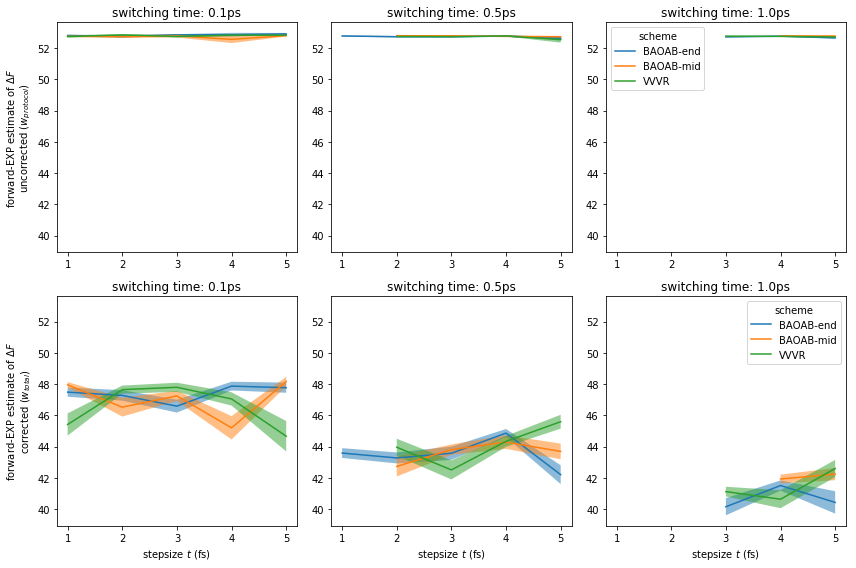

In [20]:
ax = None
scale = 4
plt.figure(figsize=(scale * n_switching_times, scale * n_estimators))

plot_id = 1
for l in range(len(estimators)):
    for j in range(n_switching_times):
        ax = plt.subplot(2,n_switching_times, plot_id, sharey=ax, sharex=ax)
        plot_id += 1
        for i in range(n_schemes):
            means = estimates[i,:,j,l,0]
            unc = estimates[i,:,j,l,1]
            plt.plot(stepsizes, means, label=schemes[i].split(' ')[0])
            plt.fill_between(stepsizes, means - unc, means + unc, alpha=0.5)
        plt.title('switching time: {}ps'.format(switching_times[j]))
        if j == 0:
            plt.ylabel(r'forward-EXP estimate of $\Delta F$' + '\n' + estimators[l])
        if l == n_estimators - 1:
            plt.xlabel(r'stepsize $t$ (fs)')
        if j == n_switching_times -1:
            plt.legend(title='scheme', loc='best')
plt.tight_layout()
plt.savefig('initial-results-alchemical-ala2.jpg', dpi=300, bbox_inches='tight')